In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
import scipy.interpolate
import Config
import tensorflow as tf

In [2]:
pixels = np.arange(50000)
injections = np.random.randint(0, high = 400, size = 10000) + 100
expTime = np.random.randint(0, high = 501, size = 10000) + 100
skyVar = 3*np.random.rand(10000) + 2

In [3]:
perValuesExp = 0.0004 * (expTime - 350) + 1
noiseExp = 0*(0.02 * np.random.rand(10000) - 0.01)
perValuesVar = 1 - 0.05 * (skyVar - 3.5)
noiseVar = 0*(0.02 * np.random.rand(10000) - 0.01)

In [4]:
detections = np.round(injections * Config.aveEffs * (perValuesExp + noiseExp) * (perValuesVar + noiseVar))

In [5]:
for i in range(len(detections)):
    if detections[i] > injections[i]:
        detections[i] = injections[i]

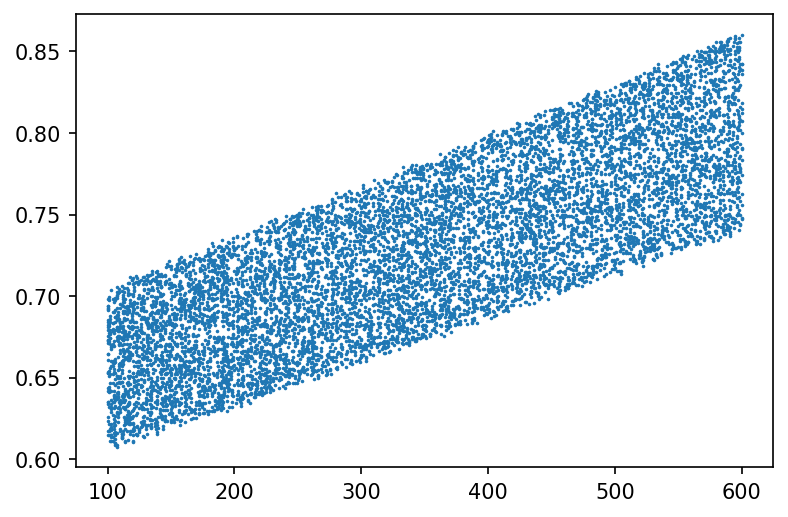

In [6]:
plt.figure(dpi = 150)
plt.scatter(expTime, detections/injections, s = 0.5)
plt.show()

In [7]:
aveEff = np.sum(detections) / np.sum(injections)

In [8]:
xValuesExp = np.linspace(Config.expBins[0][0], Config.expBins[0][1], Config.numBins, endpoint = False) + (Config.expBins[0][0] - Config.expBins[0][1]) / (2 * Config.numBins)
xValuesVar = np.linspace(Config.varBins[0][0], Config.varBins[0][1], Config.numBins, endpoint = False) + (Config.varBins[0][0] - Config.varBins[0][1]) / (2 * Config.numBins)

In [9]:
def binIndicesByCondition(cond, condMin, condMax, numBins): # This bins together the indices.
    binBounds = np.linspace(condMin, condMax, (numBins + 1), endpoint = True)
    indByBin = []
    for i in range(len(binBounds) - 1):
        validIndices = np.array(np.where((cond >= binBounds[i]) & (cond <= binBounds[i + 1]))[0])
        # I used both >= and <= even though this could result in repeats since what we're after is the "detection efficiency"
        # in a certain range of conditions and I didn't think repeats would really matter. Easy switch if desired though.
        indByBin.append(validIndices)
    return np.array(indByBin, dtype = object)

In [10]:
# This generates the indices for each bin.
binIndExp = binIndicesByCondition(expTime, Config.expBins[0][0], Config.expBins[0][1], Config.numBins)
binIndVar = binIndicesByCondition(skyVar, Config.varBins[0][0], Config.varBins[0][1], Config.numBins)

In [11]:
percentBinsExp = []

for i in range(len(binIndExp)):
    totalDet = np.sum(detections[binIndExp[i]]) # Total number of detections within the bin.
    totalInj = np.sum(injections[binIndExp[i]])
    percentBinsExp.append(totalDet / totalInj) # Total effective area within the bin.

relPerBinsExp = np.array(percentBinsExp) / aveEff # This normalizes the data, relative percent bins.

percentBinsVar = []

for i in range(len(binIndVar)):
    totalDet = np.sum(detections[binIndVar[i]]) # Total number of detections within the bin.
    totalInj = np.sum(injections[binIndVar[i]])
    percentBinsVar.append(totalDet / totalInj) # Total effective area within the bin.

relPerBinsVar = np.array(percentBinsVar) / aveEff # This normalizes the data, relative percent bins.

In [12]:
corrWeightsExp = 1/relPerBinsExp
corrWeightsVar = 1/relPerBinsVar

In [13]:
f = scipy.interpolate.interp1d(xValuesExp, corrWeightsExp, bounds_error = False, fill_value = "extrapolate")
correctionsExp = f(expTime)
f = scipy.interpolate.interp1d(xValuesVar, corrWeightsVar, bounds_error = False, fill_value = "extrapolate")
correctionsVar = f(skyVar)
relPerDet = (detections / injections) / aveEff
realCorr = 1/(relPerDet)

In [14]:
weights = np.random.rand(2)
learningRate = 0.000001

In [15]:
indCorrs = np.array([correctionsExp, correctionsVar])

In [16]:
compCorr = np.ones_like(realCorr)
for i in range(2):
    compCorr = compCorr * (weights[i]*(indCorrs[i] - 1) + 1)

In [17]:
originalCost = np.sum((realCorr - compCorr)**2 * (injections))

In [18]:
for j in range(10000):
    deltaWeights = np.zeros(2)
    for i in range(2):
        deltaWeights[i] = learningRate * np.sum((realCorr - compCorr) * compCorr * (indCorrs[i] - 1) * (injections) / (weights[i]*(indCorrs[i] - 1) + 1))
    weights += deltaWeights
    # weights[np.where(weights < 0)[0]] = 0
    compCorr = np.ones_like(realCorr)
    for i in range(2):
        compCorr = compCorr * (weights[i]*(indCorrs[i] - 1) + 1)
    cost = np.sum((realCorr - compCorr)**2 * (injections)) / originalCost

In [19]:
cost

0.014013966157374854

In [20]:
weights

array([0.99029914, 1.01373677])

In [21]:
# plt.figure(dpi = 150)
# plt.plot(xValuesVar, corrWeightsVar)
# plt.show()

In [22]:
# weights = np.array([1, 1])
# compCorr = np.ones_like(realCorr)
# for i in range(2):
#     compCorr = compCorr * (weights[i]*(indCorrs[i] - 1) + 1)
# cost = np.sum((realCorr - compCorr)**2 * (injections)) / originalCost
# cost

In [23]:
calcCorr = (weights[0] * (correctionsExp - 1) + 1) * (weights[1] * (correctionsVar - 1) + 1)

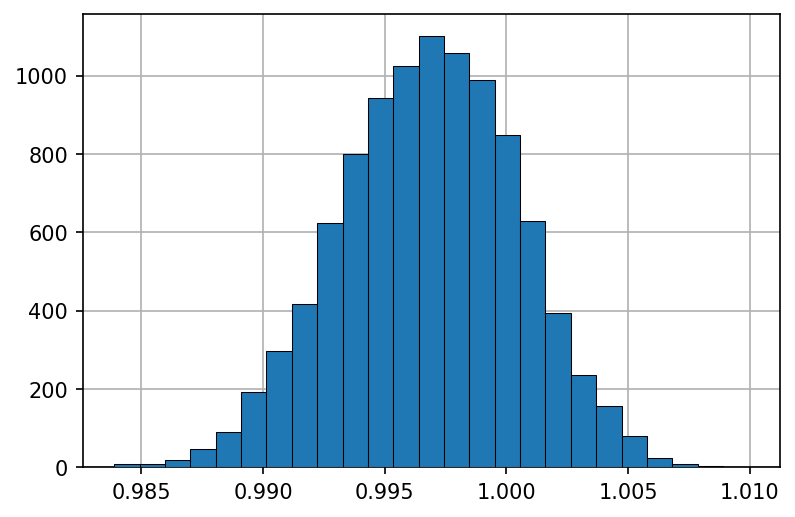

In [24]:
difference = calcCorr / realCorr
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(difference, bins = 25, edgecolor='black', linewidth=.5, zorder = 3)
# plt.yscale('log')
plt.show()

In [25]:
np.average(difference)

0.9968136265830632

### MCMC

In [26]:
weights = np.random.rand(2)
learningRate = 0.000001

In [27]:
compCorr = np.ones_like(realCorr)
for i in range(2):
    compCorr = compCorr * (weights[i]*(indCorrs[i] - 1) + 1)

In [28]:
originalCost = np.sum((realCorr - compCorr)**2 * (injections))
prevCost = originalCost

minCost = originalCost
minWeights = np.copy(weights)

In [29]:
for _ in range(100000):
    deltaWeights = np.random.normal(scale = 0.001, size = 2)
    potWeights = weights + deltaWeights
    potWeights[np.where(potWeights < 0)[0]] = 0
    compCorr = np.ones_like(realCorr)
    for i in range(2):
        compCorr = compCorr * (weights[i]*(indCorrs[i] - 1) + 1)
    cost = np.sum((realCorr - compCorr)**2 * (injections))
    moveChance = prevCost / cost
    if np.random.rand(1) <= moveChance:
        prevCost = cost
        weights = np.copy(potWeights)
        if cost < minCost:
            minCost = cost
            minWeights = np.copy(weights)

In [30]:
minCost / originalCost

0.8019444641649486

In [31]:
minWeights

array([0.39747202, 0.38819445])

In [32]:
calcCorr = (minWeights[0] * (correctionsExp - 1) + 1) * (minWeights[1] * (correctionsVar - 1) + 1)

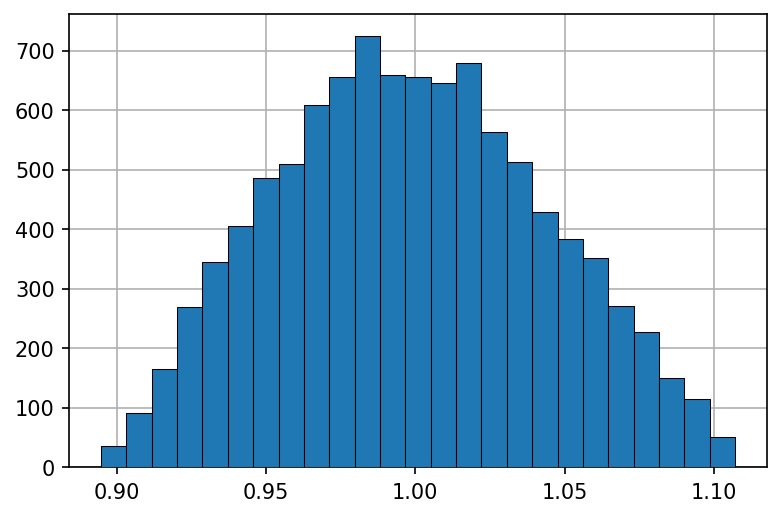

In [33]:
difference = calcCorr / realCorr
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(difference, bins = 25, edgecolor='black', linewidth=.5, zorder = 3)
# plt.yscale('log')
plt.show()

In [34]:
np.average(difference)

0.9986103797015996

### Neural Network

In [35]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(50, activation='relu', input_shape = (2,)),
  tf.keras.layers.Dense(50, activation='relu'),
  tf.keras.layers.Dense(1)
])

2022-08-03 15:26:15.371613: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [36]:
trainIndices = np.full(len(indCorrs[0]), True, dtype = bool)
for i in range(len(trainIndices)):
    if np.random.rand() > 0.85:
        trainIndices[i] = False

xTrain = indCorrs[:,trainIndices].T
yTrain = np.array(realCorr[trainIndices])

In [37]:
xTest = indCorrs[:,~trainIndices].T
yTest = np.array(realCorr[~trainIndices])

In [38]:
# predictions = model(xTrain)

In [39]:
# loss_object = tf.keras.losses.MeanSquaredError()

In [40]:
# def loss(model, x, y):
#     # training=training is needed only if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     y_ = model(x)

#     return loss_object(y_true=y, y_pred=y_)

In [41]:
# def grad(model, inputs, targets):
#     with tf.GradientTape() as tape:
#         loss_value = loss(model, inputs, targets)
#     return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [42]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

In [43]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(x = xTrain, y = yTrain, epochs = 100);

Epoch 1/100
267/267 [==============================] - 2s 4ms/step - loss: 0.0126
Epoch 2/100
267/267 [==============================] - 1s 4ms/step - loss: 0.0015
Epoch 3/100
267/267 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 4/100
267/267 [==============================] - 1s 5ms/step - loss: 0.0012
Epoch 5/100
267/267 [==============================] - 1s 4ms/step - loss: 0.0011
Epoch 6/100
267/267 [==============================] - 1s 5ms/step - loss: 8.7512e-04
Epoch 7/100
267/267 [==============================] - 1s 5ms/step - loss: 6.5504e-04
Epoch 8/100
267/267 [==============================] - 1s 5ms/step - loss: 4.4052e-04
Epoch 9/100
267/267 [==============================] - 1s 5ms/step - loss: 2.3289e-04
Epoch 10/100
267/267 [==============================] - 1s 3ms/step - loss: 9.3582e-05
Epoch 11/100
267/267 [==============================] - 1s 3ms/step - loss: 2.8508e-05
Epoch 12/100
267/267 [==============================] - 1s 4ms/step - lo

In [44]:
yPredTest = model(xTest)

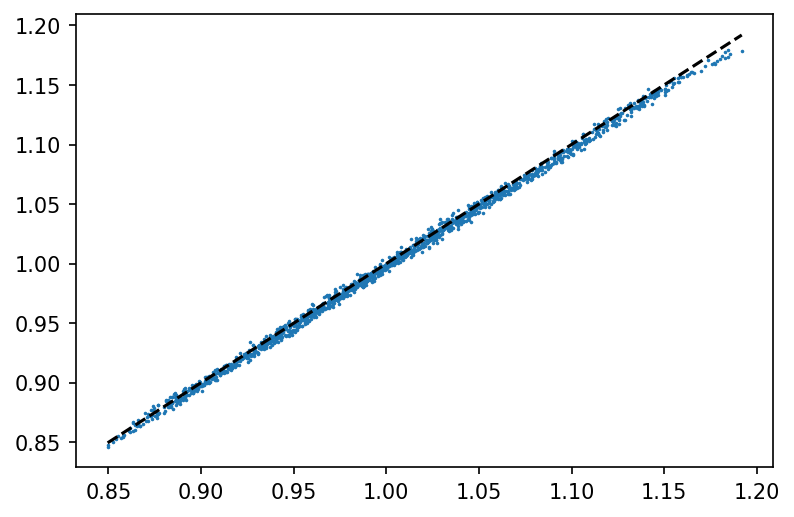

In [45]:
plt.figure(dpi = 150)
plt.scatter(yTest, yPredTest, s = 0.5)
plt.plot([np.min(yTest), np.max(yTest)], [np.min(yTest), np.max(yTest)], color = 'k', linestyle = '--')
plt.show()

In [46]:
yPredTrain = model(xTrain)

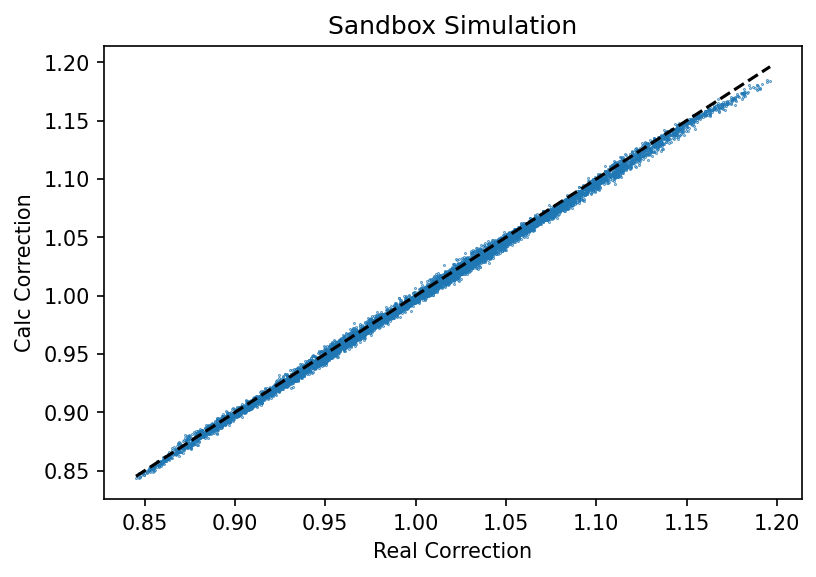

In [47]:
plt.figure(dpi = 150)
plt.scatter(yTrain, yPredTrain, s = 0.1)
plt.plot([np.min(yTrain), np.max(yTrain)], [np.min(yTrain), np.max(yTrain)], color = 'k', linestyle = '--')
plt.xlabel('Real Correction')
plt.ylabel('Calc Correction')
plt.title('Sandbox Simulation')
plt.show()

In [48]:
yPredTest.numpy().T[0]

array([1.0883899 , 0.8644376 , 0.98095274, ..., 1.0956473 , 0.96427643,
       1.0349045 ], dtype=float32)

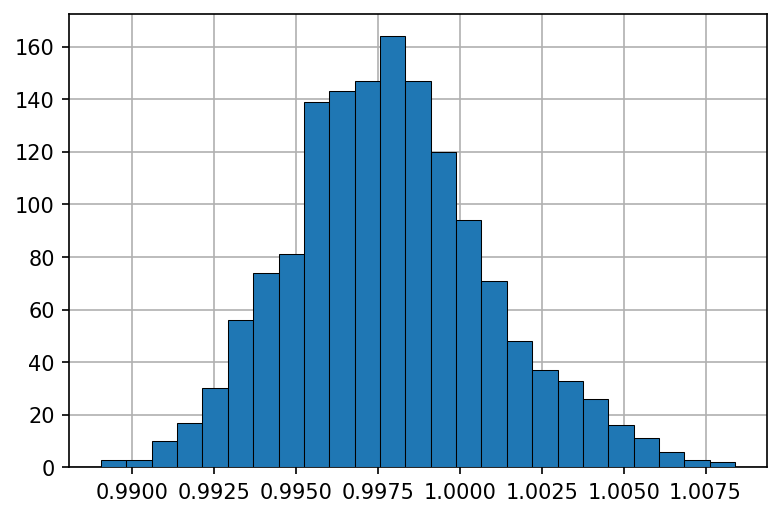

In [49]:
difference = yPredTest.numpy().T[0] / yTest
plt.figure(dpi = 150)
plt.grid(zorder = 0)
plt.hist(difference, bins = 25, edgecolor='black', linewidth=.5, zorder = 3)
# plt.yscale('log')
plt.show()

In [50]:
np.average(difference)

0.9978746060479039